In [1]:
import os
import glob
import hist
import dask
import uproot
import awkward as ak
import dask_awkward as da
import dask.dataframe as dd
import dask_histogram as dh
from dask.diagnostics import ProgressBar
import boost_histogram as bh
from particle import Particle, ParticleNotFound

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd

from concurrent.futures import ThreadPoolExecutor

# Meta-Daten und Tabellen für IDs

In [2]:
file = "/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/1b6c1fe/Analysis/test_0.root"
rfile = uproot.open(file)

print(f"The file contains {len(rfile.keys())} keys:")
for key in rfile.keys():
    print(f"  {key}")

print(f"\nExecuted with G4VERSION {rfile['G4VERSION_TAG'].member('fTitle')}")
print(f"Total runtime: {rfile['G4RUNTIME'].member('fVal')} seconds")
print(f"Number of events: {rfile['events/nbevents'].member('fVal')}")

print(f"\nUsing the macros:")
for macro in rfile["macros"].keys():
    print(f"--> {rfile['macros'][macro].member('fName')}")
    print(f"    File content hidden for brevity ...")
    for line in rfile["macros"][macro].member('fTitle').splitlines():
        print(f"    {line}")
    print("")

The file contains 15 keys:
  G4VERSION_TAG;1
  MC_TAG;1
  MCVERSION_TAG;1
  macros;1
  macros/preinit.mac;1
  macros/det_setup.mac;1
  macros/src_neutron.mac;1
  tables;1
  tables/process_subtypes;1
  tables/logical_volumes;1
  tables/physical_volumes;1
  events;1
  events/nbevents;1
  events/events;1
  G4RUNTIME;1

Executed with G4VERSION $Name: geant4-10-06-patch-02 $
Total runtime: 1294.987471715 seconds
Number of events: 100000

Using the macros:
--> preinit.mac
    File content hidden for brevity ...
    # ./macros/NeutronShielding/preinit.mac
    
    /control/verbose 0
    /run/verbose 0
    /event/verbose 0
    /tracking/verbose 0
    
    # select how would you like to simulate radioactive decays
    # setting 0 means that you would like to simulate the full decay chain in a single event
    # setting 1 means that you want to manually postpone all radioactive decays
    # If postpone is on each new isotope will be written in its own event together with subsequent gamma decays


In [3]:
data_path = "/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/1b6c1fe/Analysis"
data_file_pattern = "test_*.root"

min_data_file_size = 5 * 1024 * 1024
data_files = glob.glob(f"{data_path}/{data_file_pattern}")
print(f"Found {len(data_files)} files matching pattern '{data_file_pattern}' in '{data_path}'.")

uproot_files = [{f:"events/events"} for f in data_files if os.path.getsize(f) > min_data_file_size]
print(f"Available keys in uproot files: {uproot.open(uproot_files[0]).keys()}")

Found 100 files matching pattern 'test_*.root' in '/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/1b6c1fe/Analysis'.
Available keys in uproot files: ['eventid', 'type_pri', 'type_pri_id', 'e_pri', 'xp_pri', 'yp_pri', 'zp_pri', 'cx_pri', 'cy_pri', 'cz_pri', 'vol_pri', 'vol_pri_hash', 'NSave', 'Save_flag', 'Save_desc', 'Save_type', 'Save_x', 'Save_y', 'Save_z', 'Save_cx', 'Save_cy', 'Save_cz', 'Save_e', 'Save_t', 'Save_eventid', 'Save_trackid', 'NNAct', 'NAct_eventid', 'NAct_trackid', 'NAct_parentid', 'NAct_t', 'NAct_volume', 'NAct_volume_hash', 'NAct_x', 'NAct_y', 'NAct_z', 'NAct_process_name', 'NAct_process_category', 'NAct_process_ID', 'NAct_particle_name', 'NAct_particle_lifetime', 'NAct_particle_id', 'NAct_particle_atomicnumber', 'NAct_particle_mass', 'NAct_particle_excitationEnergy']


In [4]:
rfile = uproot.open(data_files[0])

physical_volumes = {}
for k,v in zip(*rfile["tables/physical_volumes"].arrays(library="np", how=list)):
    physical_volumes = {**physical_volumes, **{k: v for k, v in zip(k, v)}}

def get_volume_name(volume_id):
    """Get the volume name from the volume ID."""
    _hashes = {v:k for k,v in physical_volumes.items()}
    if volume_id in _hashes:
        return _hashes[volume_id]
    else:
        return f"Unknown volume ID {volume_id}"

subtypes_table = rfile["tables/process_subtypes"].arrays(library="np")

particle_ids = {}
for k,v in zip(subtypes_table['particle_id'], subtypes_table['particle_name']):
    particle_ids = {**particle_ids, **{k: v for k, v in zip(k, v)}}

def get_particle_name(particle_id):
    """Get the particle name from the particle PDG code."""
    if particle_id in particle_ids:
        return particle_ids[particle_id]
    else:
        try:
            try:
                particle = Particle.from_pdgid(particle_id)
                return particle.name
            except ParticleNotFound:
                # Check if nucleus
                if (str(particle_id)[0:2] == "10"):
                    # Remove isomeric state
                    _particle_id = int(str(particle_id)[:9] + "0")
                    particle = Particle.from_pdgid(_particle_id)
                    return particle.name+f"({str(particle_id)[9:]})"
                raise
        except Exception as e:
            return f"Unknown particle code {particle_id}"

process_subtype = {}
for k,v in zip(subtypes_table['process_subtype'], subtypes_table['process_name']):
    process_subtype = {**process_subtype, **{k: v for k, v in zip(k, v)}}

def get_process_name(process_id):
    """Get the process name from the process ID."""
    if process_id in process_subtype:
        return process_subtype[process_id]
    else:
        return f"Unknown process ID {process_id}"

# Loading using dask

## Processes

In [5]:
da_processes = uproot.dask(uproot_files, filter_name=['eventid','e_pri','NAct_volume', 'NAct_particle_id', 'NAct_process_ID'], allow_missing=True, step_size="2GB")

df = da.to_dataframe(da_processes)

In [6]:
only_LXe_volume = df[df['NAct_volume'] == "LXe"]

only_LXe_volume = only_LXe_volume[['NAct_particle_id','NAct_process_ID']]

In [7]:
with ProgressBar():
    grouped_data = only_LXe_volume.groupby(['NAct_particle_id','NAct_process_ID']).size().compute()


grouped_data.index = grouped_data.index.set_levels(
    grouped_data.index.levels[0].map(lambda x: get_particle_name(x)), level = 0
)
grouped_data.index = grouped_data.index.set_levels(
    grouped_data.index.levels[1].map(lambda x: get_process_name(x)), level = 1
)


[########################################] | 100% Completed | 245.35 s


In [8]:
grouped_data[grouped_data.index.get_level_values(0).str.contains('Unknown particle code', na=True)]


Series([], dtype: int64)

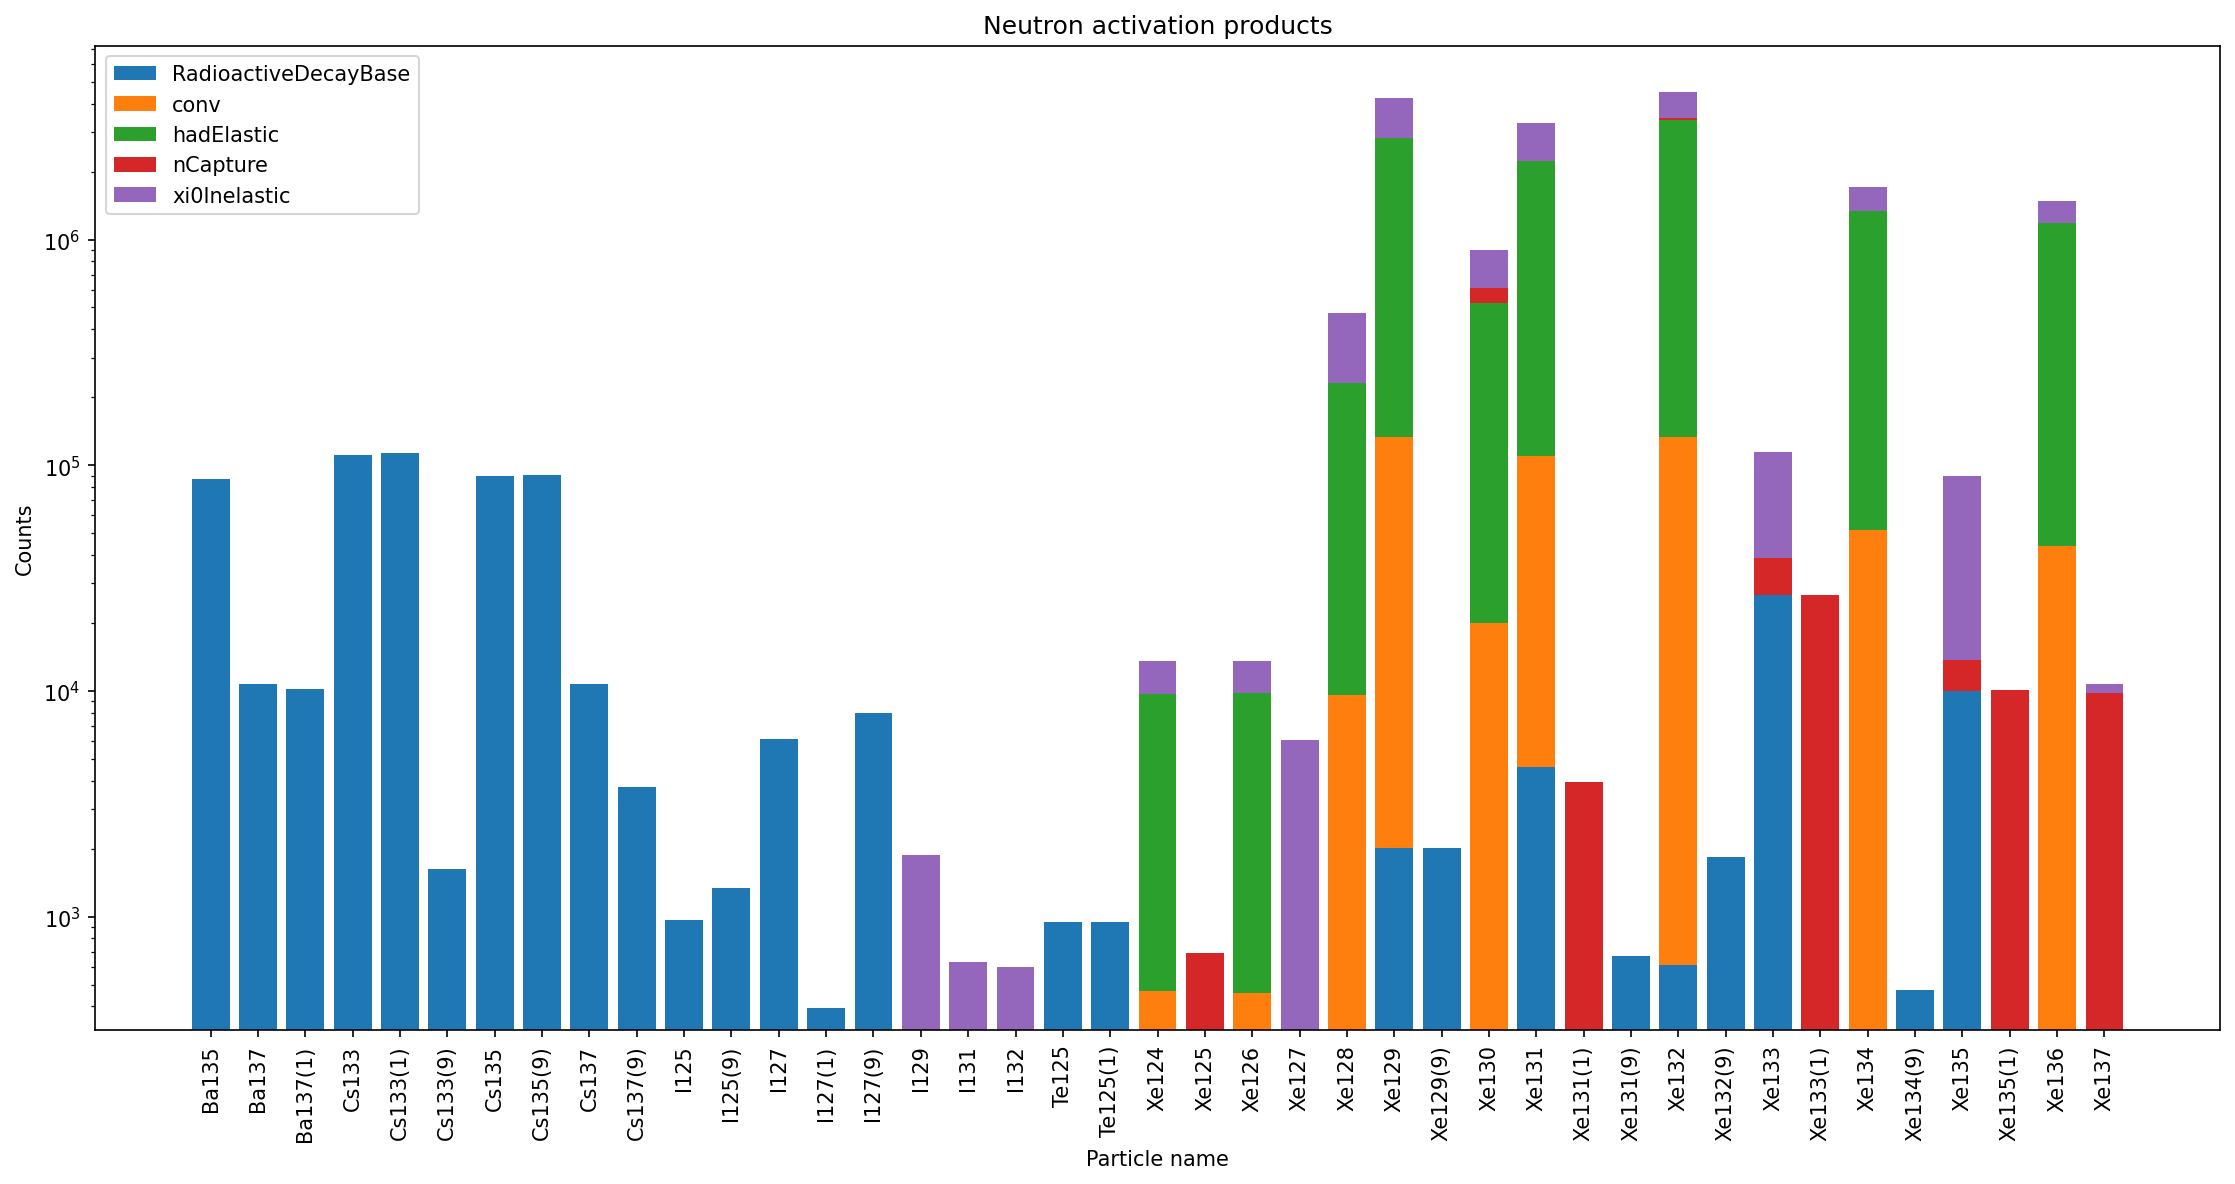

In [11]:
_data = grouped_data[grouped_data.values > 300]


_particles = np.unique(_data.index.get_level_values(0))
_processes = np.unique(_data.index.get_level_values(1))

def get_value(data,pr,p):
    try:
        return data[p,pr]
    except:
        return 0

_counts = {pr: [get_value(_data,pr,p) for p in _particles] for pr in _processes} 

plt.figure(dpi=150, figsize =(15,8))

x = np.arange(len(_particles))
bottom = np.zeros(len(_particles))
for pr in _processes:
    plt.bar(x, _counts[pr], 0.8, label=pr, bottom=bottom)
    bottom += np.array(_counts[pr])

ax = plt.gca()
ax.set_xticks(x)
ax.set_xticklabels(_particles, rotation=90, ha='center')

plt.xlabel("Particle name")
plt.ylabel("Counts")
plt.title("Neutron activation products")
plt.yscale("log")

plt.legend()
plt.savefig('./Pictures/Test_100x100000.pdf')
plt.tight_layout()
plt.show()



## Positions

In [36]:
da_positions_pri = uproot.dask(uproot_files, filter_name=['eventid','xp_pri', 'yp_pri', 'zp_pri','type_pri_id', 'vol_pri' ], allow_missing=True, step_size="2GB")
da_positions_NAct = uproot.dask(uproot_files, filter_name=['eventid','NAct_volume', 'NAct_x', 'NAct_y', 'NAct_z' ], allow_missing=True, step_size="2GB")

df_pri = da.to_dataframe(da_positions_pri)
df_NAct = da.to_dataframe(da_positions_NAct)

In [46]:
neutron = 2112

data_pri = df_pri[df_pri['type_pri_id'] == neutron]


-9110.0

In [59]:
x_range = (data_pri['xp_pri'].min().compute(), data_pri['xp_pri'].max().compute())
y_range = (data_pri['yp_pri'].min().compute(), data_pri['yp_pri'].max().compute())
z_range = (data_pri['zp_pri'].min().compute(), data_pri['zp_pri'].max().compute())



In [56]:
h = dh.histogramdd([data_pri["xp_pri"], data_pri["yp_pri"], data_pri["zp_pri"]], 
                   bins=(100, 100, 100), 
                   range=(x_range, y_range, z_range), histogram=True)


In [58]:
h.compute()

TypeError: Converting from an nplike without known data to an nplike with known data is not supported

In [57]:
plt.figure(figsize=(10, 8))
plt.imshow(np.sum(h.compute(), axis=2), extent=(x_range[0], x_range[1], y_range[0], y_range[1]), origin='lower', aspect='auto')
plt.colorbar(label='Counts')
plt.xlabel('X Position (cm)')
plt.ylabel('Y Position (cm)')
plt.show()

TypeError: Converting from an nplike without known data to an nplike with known data is not supported

<Figure size 1000x800 with 0 Axes>

## With Hist

In [ ]:
hGen = hist.Hist(hist.axis.Regular(*x_range, 200, name="xp_pri", underflow=False, overflow=False),
                 hist.axis.Regular(*y_range, 200, name="yp_pri", underflow=False, overflow=False),
                 hist.axis.Regular(*z_range, -300, name="zp_pri", underflow=False, overflow=False),
                 storage=hist.storage.Int64())

for array, report in tqdm(uproot.iterate(uproot_files, filter_name=columns, cut=None, allow_missing=True,
                                         step_size="2GB", report=True)):
    try:
        hGen.fill(ak.ravel(array["xp_pri"]),
                  ak.ravel(array["yp_pri"]),
                  ak.ravel(array["zp_pri"]))

    except Exception as e:
        print(f"Error {e}!")
        print(report)

20it [00:46,  2.32s/it]


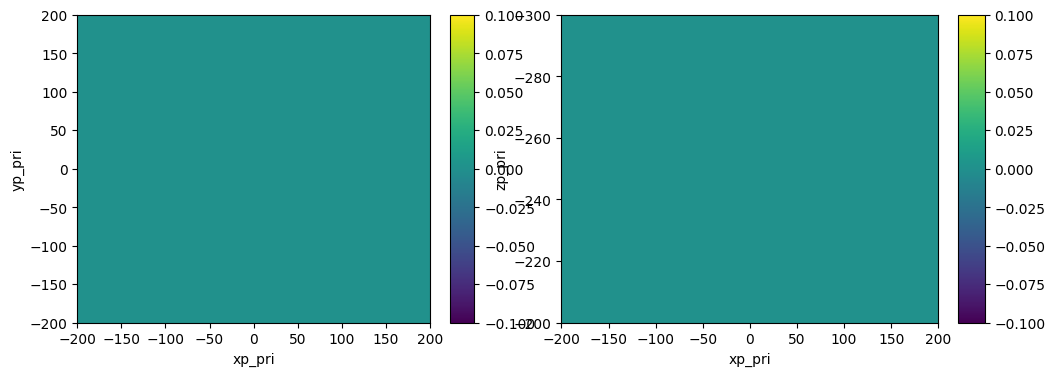

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
hGen[:,:, sum].plot2d(ax=axs[0])
hGen[:, sum, :].plot2d(ax=axs[1])
plt.show()